# Исследование объявлений о продаже квартир

***
**Данные для анализа**: данные сервиса Яндекс Недвижимость — архив объявлений за несколько лет о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет; по каждой квартире на продажу доступны два вида данных: первые вписаны пользователем, вторые — получены автоматически на основе картографических данных (например, расстояние до центра, аэропорта, ближайшего парка и водоёма).

**Задачи**: найти интересные особенности и зависимости, которые существуют на рынке недвижимости: определить рыночную стоимость объектов недвижимости и типичные параметры квартир.

Содержание:
1. [Открытие файла с данными и изучение общей информации](#1)
2. [Предобработка данных](#2)
    1. [Обработка наименований столбцов](#2.1)    
    2. [Анализ пропусков](#2.2)
    3. [Обработка значений в столбцах](#2.3)
    4. [Промежуточные выводы](#2.4)
3. [Добавление в таблицу новых столбцов](#3)
4. [Исследовательский анализ данных](#4)
    1. [Изучение параметров объектов](#3.1)  
    2. [Изучение быстроты продажи квартир](#3.2)
    3. [Какие факторы больше всего влияют на общую (полную) стоимость объекта?](#3.3)
    4. [Изучение средней цены одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений](#3.4)
    5. [Изучение средней цены каждого километра в Санкт-Петербурге](#3.5)
5. [Общий вывод](#5)

## Открытие файла с данными и изучение общей информации <a id='1'></a>

In [1]:
# Импортируем библиотеки, которые могут понадобиться при работе с данными

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
data = pd.read_csv('datasets/real_estate_data.csv', sep = '\t')
pd.set_option('display.max_columns', None)

In [2]:
# Выводим на экран первые строки датасета

data.head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [3]:
# выводим информацию о наборе данных

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

''

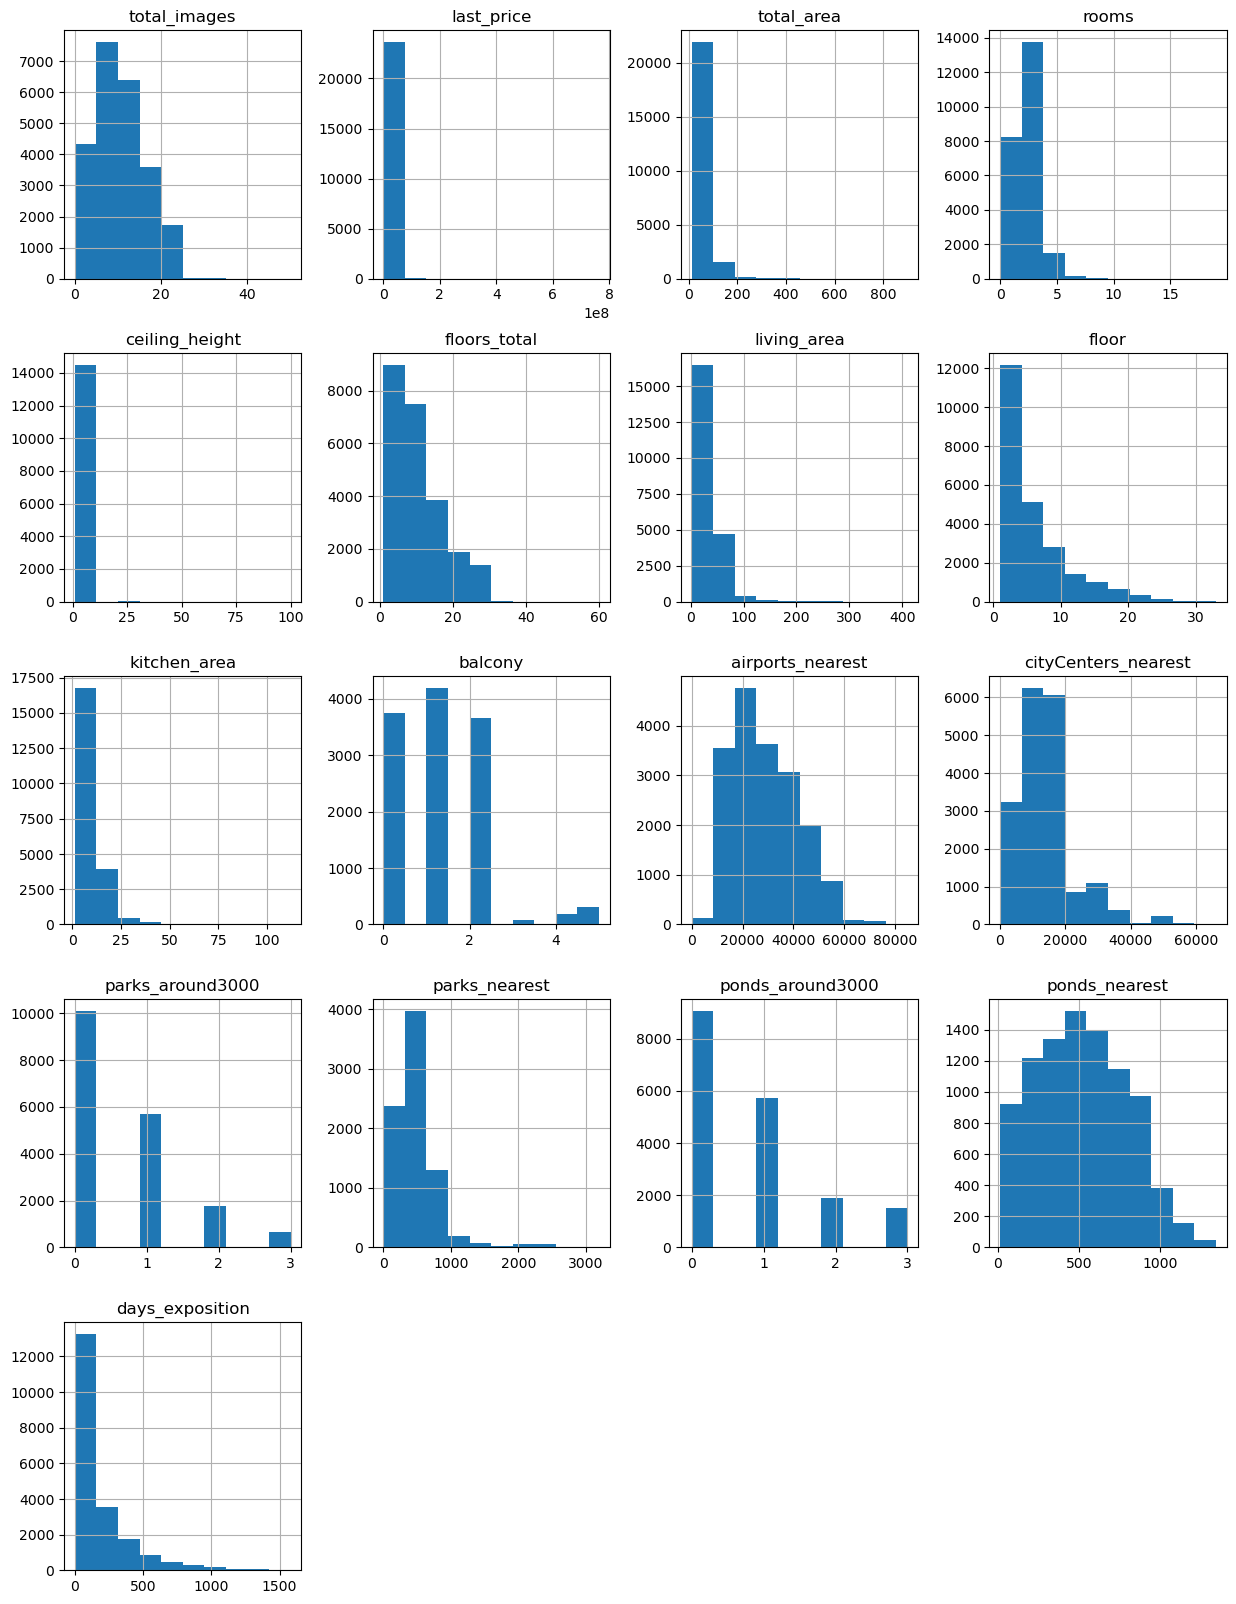

In [4]:
# Строим гистограммы по каждому столбцу

data.hist(figsize=(15, 20), bins=10)
;

****
**Промежуточные выводы по первому этапу**

- Датасет содержит 23699 строк.

- Пропусков нет совсем только в столбцах: total_images, last_price, total_area, first_day_exposition, rooms, floor, studio, open_plan. В остальных пропуски есть.

- В столбце total_images распределение похоже на нормальное и, судя по гистограмме, есть выбросы, но на качество данных и возможности анализа для целей проекта этот столбец никак не влияет, поэтому исследовать его нет смысла.

- В других столбцах с количественными переменными заметно наличие выбросов, особенно сильно это заметно в столбцах last_price, total_area, rooms, ceiling_height, living_area, и kitchen_area.

- Сразу бросаются в глаза аномальные значения в столбцах ceiling_height (высота потолка 100 метров), kitchen_area (кухни более 100 кв.м.) и total_area (квартиры площадью более 800 кв.м.). Количество этажей больше 60, балконов больше 4, комнат больше 20 - тоже сразу вызывает вопросы.

- Распределение значений в столбцах на первый взгляд (и в таком небольшом масштабе гистограмм) не выглядит необычно, за исключением увеличения количества строк с количеством балконов больше 4.

- Необходимо детальнее рассмотреть распределение и диапазоны значений на следующем этапе работы с данными.

****

## Предобработка данных <a id='2'></a>

### Обработка наименований столбцов <a id='2.1'></a>

In [5]:
# Названия столбцов датасета в целом соответствуют правилам хорошего кода. Переименуем только один столбец, касающийся расстояния
# до центра города

data = data.rename(columns={'cityCenters_nearest': 'city_centers_nearest'})

### Анализ пропусков <a id='2.2'></a>

In [6]:
# Выводим перечень столбцов с пропущенными значениями

print(data.isna().sum())

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
city_centers_nearest     5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64


### Обработка значений в столбцах <a id='2.3'></a>

#### Обработка значений в столбце is_apartment 

***
В столбце "is_apartment" слишком много пропущенных значений. При этом, можно предположить, что не все пропущенные значения подразумевают, что в объявлении именно апартаменты, а не обычная квартира. Вероятнее всего, что пропущенные значения означают, что это именно НЕ апартаменты.
***

In [7]:
# заменим пропуски в столбце "is_apartment" на False
data.loc[data['is_apartment'].isna(), 'is_apartment'] = False

# преобразуем тип значений столбца в булев, поскольку изначально ему соответствует тип 'object'
data['is_apartment'] = data['is_apartment'].astype('bool')

#### Обработка значений в столбце ceiling_height

***
В столбце ceiling_height много пропущенных значений. Пропуски могут быть связаны с тем, что владельцы квартир могут не знать точную высоту, или же считать, что этот параметр чаще всего стандартный и не требует уточнения. Действительно, чаще всего высота потолка стандартизирована и не отличается большим разбросом значений, поэтому заполнение пропусков значением средним либо медианным не приведет к искажению картины.
***

count    14504.000000
mean         2.771499
std          1.261056
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64


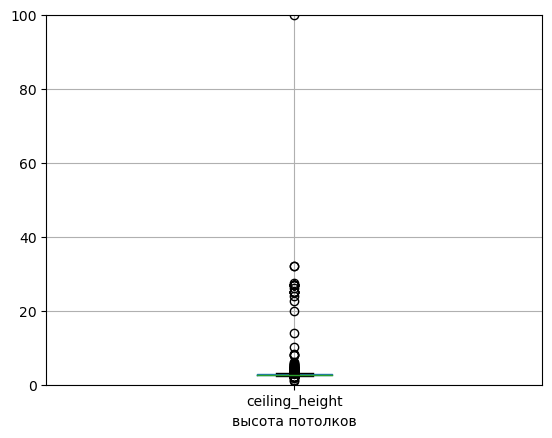

In [8]:
# Проверим значения в столбце 'ceiling_height' и их распределение

print(data['ceiling_height'].describe())

data.boxplot(column='ceiling_height')
plt.xlabel("высота потолков")
plt.ylim(0, 100);

В столбце присутствуют как аномальные значения для высоты потолка - такие, как 1.0 и 100.0, так и значения, которые, вероятнее всего, неправильно записаны, например, 26.0.

In [9]:
# Заменяем неправильно записанные значения
data.loc[data['ceiling_height'] == 22.6, 'ceiling_height'] = 2.3
data.loc[data['ceiling_height'] == 24.0, 'ceiling_height'] = 2.4
data.loc[data['ceiling_height'] == 25.0, 'ceiling_height'] = 2.5
data.loc[data['ceiling_height'] == 26.0, 'ceiling_height'] = 2.6
data.loc[data['ceiling_height'] == 27.0, 'ceiling_height'] = 2.7
data.loc[data['ceiling_height'] == 27.5, 'ceiling_height'] = 2.8
data.loc[data['ceiling_height'] == 32.0, 'ceiling_height'] = 3.2

# исходя из распределения значений, предположим, что все значения высоты потолков
# ниже 2 метров и выше 8 являются ошибкой, заменим их на медианное значение
data.loc[(data['ceiling_height'] < 2) | (data['ceiling_height'] > 8), 'ceiling_height'] = \
data.loc[(data['ceiling_height'] >= 2) & (data['ceiling_height'] <= 8), 'ceiling_height'].median()

# пропуски в столбце с потолками также заполним медианным значением
data.loc[data['ceiling_height'].isna(), 'ceiling_height'] = \
data.loc[(data['ceiling_height'] >= 2) & (data['ceiling_height'] <= 8), 'ceiling_height'].median()

#### Обработка значений в столбце total_area

***
В столбце total_area нет пропусков (это не удивительно, поскольку это один из главных параметров квартиры), однако в нем могут быть аномальные значения. Их появление может быть связано с ошибками, допущенными при внесении данных в датасет.
***

count    23699.000000
mean        60.348651
std         35.654083
min         12.000000
25%         40.000000
50%         52.000000
75%         69.900000
max        900.000000
Name: total_area, dtype: float64


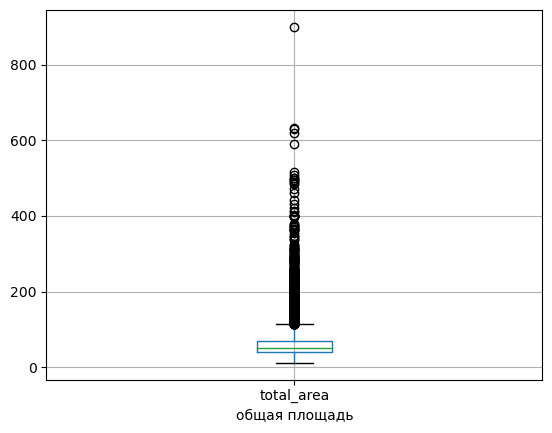

In [10]:
# изучим значения в столбце total_area

print(data['total_area'].describe())

data.boxplot(column='total_area')
plt.xlabel("общая площадь");

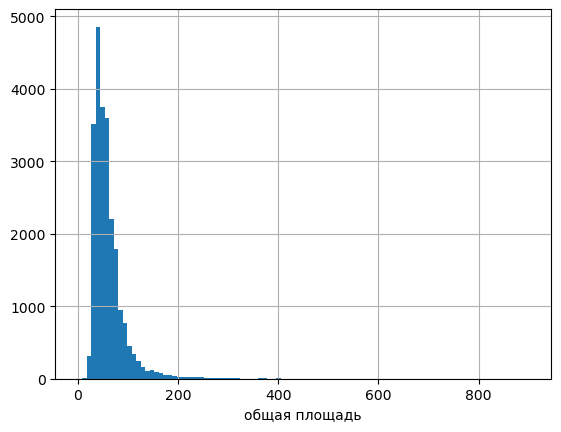

In [11]:
# строим гистограмму значений в столбце total_area
data['total_area'].hist(bins=100, range=(0, 900))
plt.xlabel("общая площадь");

Судя по диаграмме распределения и гистограмме, квартир с общей площадью более 250 кв.м. меньше чем полпроцента. Сложно оценить, являются ли эти значения ошибочными, поскольку недвижимость такой площади действительно существует. Так или иначе, на среднее и медианное значение эти квартиры существенного влияния не оказывают (медиана - 52, среднее - 60). Уберем эти значения, посчитав их выбросами.

In [12]:
# удаляем строки из датасета
data = data.query('total_area < 250')

# сбрасываем сбившиеся индексы
data = data.reset_index(drop=True)

#### Обработка значений в столбце rooms

***
Изучим данные в столбце rooms и, если необходимо, очистим данные от выбросов
***

count    23583.000000
mean         2.050969
std          1.027580
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         14.000000
Name: rooms, dtype: float64


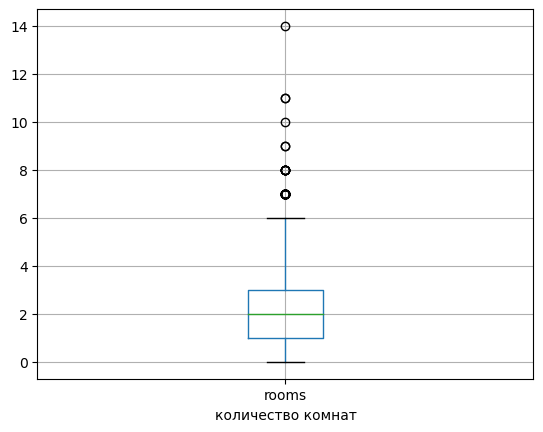

In [13]:
# изучим значения в столбце rooms
print(data['rooms'].describe())

data.boxplot(column='rooms')
plt.xlabel("количество комнат");

По разбросу видно, что квартир с комнатами больше 7 - единицы. Очистим датасет от этих строк.

In [14]:
# удаляем строки из датасета
data = data.query('rooms <= 7')

# сбрасываем сбившиеся индексы
data = data.reset_index(drop=True)

#### Обработка значений в столбце living_area

***
В столбце living_area есть пропуски. Их появление может быть связано с тем, что общую именно жилую площадь владельцы квартир могут и не знать (или не стремиться уточнить в технической документации, как и в случае с высотой потолка).
Заполнить пропуски в этом столбце сложно, поскольку этот параметр сильно зависит от планировки квартиры, а они разнообразны. Отчасти можно отталкиваться от заявленного количества комнат и заполнить пропуски медианными значениями в зависимости от количества комнат.
***

In [15]:
# заполним пропуски в столбце "living_area" медианными значениями площади, исходя из количества комнат
for rooms_count in data['rooms'].unique():
    data.loc[(data['rooms'] == rooms_count) & (data['living_area'].isna()), 'living_area'] = \
    data.loc[data['rooms'] == rooms_count, 'living_area'].median()
print(data['living_area'].isna().sum())

0


count    23569.000000
mean        33.549532
std         18.411235
min          2.000000
25%         18.300000
50%         30.200000
75%         42.400000
max        200.000000
Name: living_area, dtype: float64


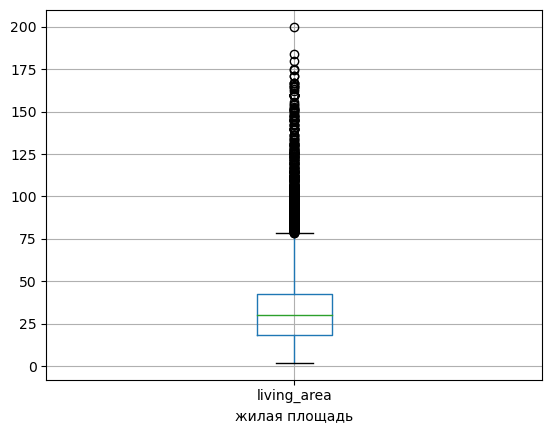

In [16]:
# изучим значения в столбце living_area
print(data['living_area'].describe())

data.boxplot(column='living_area')
plt.xlabel("жилая площадь");

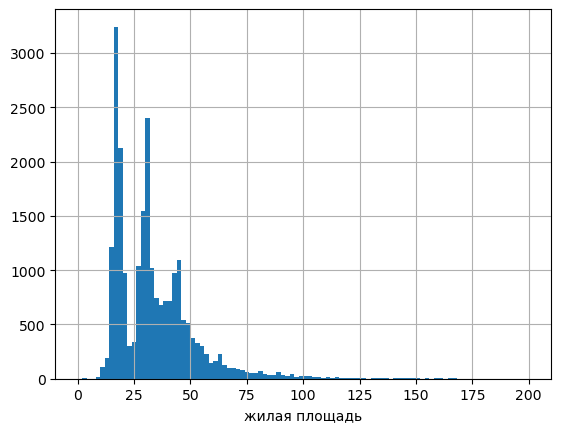

In [17]:
data['living_area'].hist(bins=100, range=(0, 200))
plt.xlabel("жилая площадь");

In [18]:
# Удаляем выбивающиеся из первого квартиля значения в столбце living_area
data.loc[data['living_area'] <= 10, 'living_area'] = np.nan

#### Обработка значений в столбце kitchen_area

***
Исследуем влияние типа планировки (студии и свободные планировки) на значения в столбце kitchen_area, а также пропуски в этом столбце.
***

In [19]:
# считаем общее количество строк со студиями и свободной планировкой
print(data[(data['open_plan'] == True) | (data['studio'] == True)]['total_area'].count())

215


In [20]:
# проверяем, какая площадь кухни указана для студий и свободных планировок
print(data[((data['open_plan'] == True) | (data['studio'] == True)) & (data['kitchen_area'] > 0)])

Empty DataFrame
Columns: [total_images, last_price, total_area, first_day_exposition, rooms, ceiling_height, floors_total, living_area, floor, is_apartment, studio, open_plan, kitchen_area, balcony, locality_name, airports_nearest, city_centers_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest, days_exposition]
Index: []


Можно предположить, что площадь кухни в студиях и свободных планировках не указана не по ошибке, а из-за специфики: кухня в таких планировках обычно совмещена с жилым пространством или не выделена из него. В этой связи пропуски в столбце kitchen_area для студий и свободных планировок заполнять не следует.

Вместе с тем, в столбце 'kitchen_area' много пропусков. Попробуем их заполнить.

In [21]:
# Исходя из данных, имеющихся в датасете, можно заполнить площадь кухни исходя из разницы между
# общей площадью и жилой площадью, применив корректирующий коэффициент. Дляя этого создаем фукнкцию,
# которая заполнит пропуски результатом вычисления математической операции
def kitchen_fillna(row):
    kitchen_area = row['kitchen_area']
    total_area = row['total_area']
    living_area = row['living_area']
    studio = row['studio']
    open_plan = row['open_plan']
    if np.isnan(kitchen_area) == False:
        return kitchen_area
    elif (studio == True) | (open_plan == True):
        return kitchen_area
    else:
        return (total_area - living_area) * 0.8

data['kitchen_area'] = data.apply(kitchen_fillna, axis=1)

***
Три параметра - общая площадь квартиры, жилая площадь и площадь кухни - могут во взаимосвязи давать противоречие, например, если сумма площади кухни и жилой площади больше общей площади квартиры. От таких аномалий лучше избавиться.
***

In [22]:
# Проверим, есть ли в датасете строки, в которых площадь кухни + жилая площадь больше общей площади
data[(data['kitchen_area'] + data['living_area']) > data['total_area']]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
183,7,2600000.0,30.20,2018-02-14T00:00:00,1,2.65,9.0,26.10,5,False,False,False,6.20,NaN,Санкт-Петербург,13952.0,15031.0,0.0,NaN,1.0,824.0,12.0
543,9,4700000.0,23.80,2018-12-28T00:00:00,1,2.65,18.0,20.00,9,False,False,False,5.00,NaN,Санкт-Петербург,9731.0,11849.0,0.0,NaN,0.0,NaN,108.0
549,8,3100000.0,31.59,2018-03-08T00:00:00,1,2.70,19.0,30.55,2,False,False,False,9.28,2.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,70.0
598,12,5600000.0,53.70,2017-04-18T00:00:00,2,2.50,12.0,48.30,5,False,False,False,7.00,2.0,Санкт-Петербург,50477.0,13252.0,2.0,220.0,1.0,1250.0,167.0
691,1,3364930.0,34.69,2014-11-27T00:00:00,1,2.64,25.0,23.43,25,False,False,False,23.43,2.0,Санкт-Петербург,43396.0,12153.0,0.0,NaN,0.0,NaN,574.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21795,14,11990000.0,91.40,2016-05-16T00:00:00,2,2.65,16.0,62.00,12,False,False,False,32.40,0.0,Санкт-Петербург,10934.0,12551.0,0.0,NaN,0.0,NaN,93.0
21835,0,5200000.0,46.00,2018-07-20T00:00:00,2,2.65,5.0,44.00,5,False,False,False,8.00,1.0,Санкт-Петербург,14103.0,15182.0,1.0,488.0,0.0,NaN,7.0
22181,8,1850000.0,41.00,2017-12-18T00:00:00,3,2.50,5.0,45.00,5,False,False,False,-3.20,NaN,деревня Пудомяги,NaN,NaN,NaN,NaN,NaN,NaN,45.0
22230,6,2050000.0,17.20,2019-01-13T00:00:00,1,2.77,23.0,17.60,1,False,False,False,-0.32,NaN,Санкт-Петербург,33645.0,13513.0,0.0,NaN,0.0,NaN,7.0


Всего 101 строка. Таких строк, с одной стороны, немного (меньше чем полпроцента), с другой стороны, эти данные явно недостоверны. Восстановить правильные значения для этих строк возможным не представляется. Поэтому такие строки удаляем из датасета.

In [23]:
# удаляем строки из датасета
data = data.query('(kitchen_area + living_area) < total_area')

# сбрасываем сбившиеся индексы
data = data.reset_index(drop=True)

count    23128.000000
mean        11.268185
std          7.365207
min          0.320000
25%          7.100000
50%          9.600000
75%         12.400000
max        132.400000
Name: kitchen_area, dtype: float64


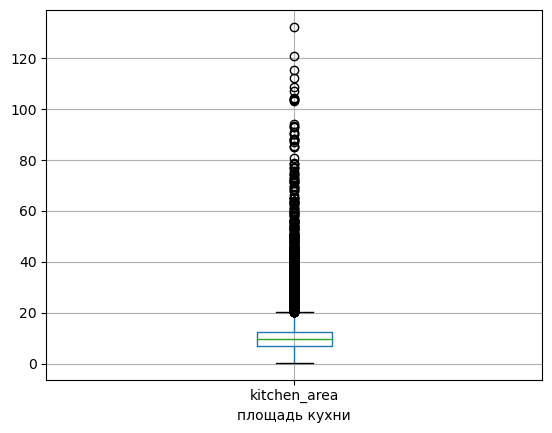

In [24]:
# изучим значения в столбце kitchen_area
print(data['kitchen_area'].describe())

data.boxplot(column='kitchen_area')
plt.xlabel("площадь кухни");

Text(0.5, 0, 'площадь кухни')

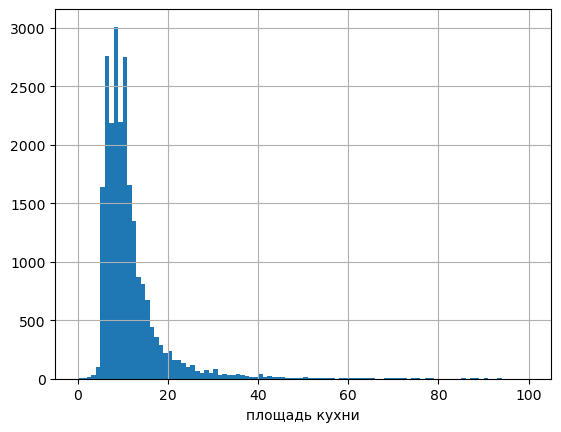

In [25]:
# строим гистограмму значений в столбце kitchen_area
data['kitchen_area'].hist(bins=100, range=(0, 100))
plt.xlabel("площадь кухни")

Исходя из распределения данных, видно, что явно выбивающиеся значения - кухни площадью менее 5 и более 45 квадратных метров. Избавимся от выбивающихся значений.

In [26]:
# Удаляем выбивающиеся значения в столбце kitchen_area
data.loc[(data['kitchen_area'] <= 5) | (data['kitchen_area'] >= 45), 'kitchen_area'] = np.nan

#### Обработка значений в столбце balcony

***
В столбце "balcony" много пропусков, и можно предположить, что они связаны с тем, что пропуски стоят в случаях, когда 
балконов в квартире нет (иначе, скорее всего, было бы указано количество). 
***

In [27]:
# Заменим пропуски в столбце "balcony" на 0
data.loc[data['balcony'].isna(), 'balcony'] = 0.0

In [28]:
# Преобразуем тип значений в столбце balcony в целочисленный, поскольку дробным количество балконов быть не может
data['balcony'] = data['balcony'].astype(int)

#### Обработка значений в столбце locality_name

***
В столбце locality_name всего 49 пропусков. Восстановить название населенного пункта не представляется возможным, поэтому заполним их произвольно выбранным значением и очистим имеющиеся в датасете данные
***

In [29]:
# Заполним пропуски произвольным значением unknown
data.loc[data['locality_name'].isna(), 'locality_name'] = 'unknown'

# очистим названия населенных пунктов в столбце locality_name
data['locality_name'] = data['locality_name'].str.replace('посёлок', 'поселок')
data['locality_name'] = data['locality_name'].str.replace('городской поселок', 'поселок городского типа')
data['locality_name'] = data['locality_name'].str.replace('поселок станции', 'поселок при железнодорожной станции')
data['locality_name'] = data['locality_name'].str.replace('садоводческое некоммерческое товарищество', 'садовое товарищество')
data['locality_name'] = data['locality_name'].str.replace('поселок Рябово', 'поселок городского типа Рябово')
data['locality_name'] = data['locality_name'].str.replace('поселок Мурино', 'Мурино')

#### Обработка значений в столбце last_price

***
Преобразуем тип данных в столбце last_price и изучим значения, проверим разброс значений 
***

In [30]:
# преобразуем тип данных в целочисленный, т.к. копейки (даже если и указаны) не важны для анализа
data['last_price'] = data['last_price'].astype(int)

count    2.312800e+04
mean     6.209263e+06
std      7.001036e+06
min      1.219000e+04
25%      3.450000e+06
50%      4.650000e+06
75%      6.750000e+06
max      3.300000e+08
Name: last_price, dtype: float64


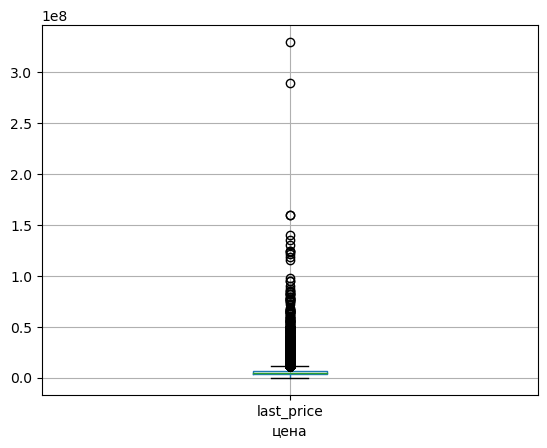

In [31]:
print(data['last_price'].describe())

data.boxplot(column='last_price')
plt.xlabel("цена");

В глаза бросаются выбросы значений. Значений больше 100 млн всего 14, скорее всего, от них можно избавиться, не повлияв на общую картину.

In [32]:
# удаляем строки из датасета
data = data.query('last_price <= 100000000')

# сбрасываем сбившиеся индексы
data = data.reset_index(drop=True)

#### Обработка значений в столбце first_day_exposition

***
Преобразуем тип данных в столбце first_day_exposition
***

In [33]:
# тип значений в столбце "first_day_exposition" - object. Преоброазуем тип данных в этом столбце в дату
data['first_day_exposition']= pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

#### Обработка значений в столбце floors_total

***
В столбце floors_total есть пропуски, но их немного, и заполнить их достоверными данными не представляется возможным. Рассмотрим имеющиеся данные в этом столбце и очистим от выбросов, если они обнаружатся.
***

count    23035.000000
mean        10.640721
std          6.566187
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64


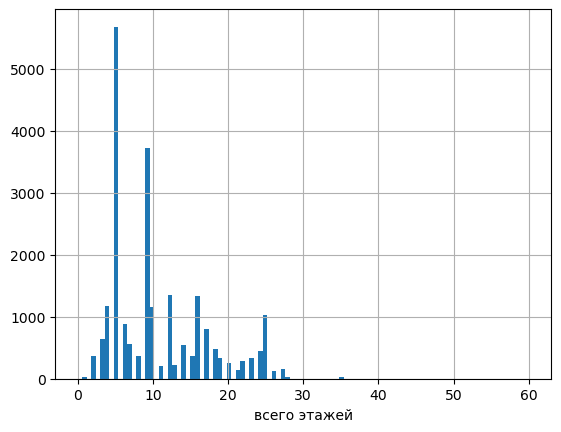

In [34]:
print(data['floors_total'].describe())
data['floors_total'].hist(bins=100, range=(0, 60))
plt.xlabel("всего этажей");

Исходя из информации в открытых источниках, самым высоким жилым домом в Санкт-Петербурге и области является 37-этажный жилой комплекс. Исходя из распределения, в датасете объектов недвижимости с такой этажностью действительно мало. Удалим строки с этажностью выше указанной.

In [35]:
# удаляем строки из датасета

data = data.query('floors_total <= 37')

# сбрасываем сбившиеся индексы

data = data.reset_index(drop=True)

In [36]:
# Преобразуем тип значений в столбце floors_total в целочисленный, поскольку количество этажей не может быть дробным

data['floors_total'] = data['floors_total'].astype(int)

#### Обработка значений в столбцах airports_nearest, city_centers_nearest, parks_around3000, parks_nearest, ponds_around3000 и ponds_nearest

В столбцах airports_nearest, city_centers_nearest, parks_around3000, parks_nearest, ponds_around3000 и ponds_nearest исходя из описания проекта содержатся картографические данные, заполняемые автоматически. Соответственно, пропуски в этих столбцах по большей части могут быть связаны с несовершенством алгоритмов или техническими сбоями.
В частности, пропуски одновременно в столбцах city_centers_nearest, parks_around3000, ponds_around3000 и ponds_nearest  содержатся в одних и тех же строках.
Для их заполнения у нас нет данных. Если заполнить эти пропуски средними/медианными значениями исходя из названия населенного пункта - это, на наш взгляд, даст значения, недостаточно точные для анализа. Поэтому оставим их пустыми.

****
### Промежуточные выводы по второму этапу <a id='2.4'></a>

В датасете обнаружены недостатки: пропущенные значения, неправильные типы данных, аномальные значения.

Обработка пропусков:
+ Пропуски в столбцах airports_nearest, city_centers_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest, скорее всего, связаны с несовершенством алгоритмов или техническими сбоями. Эти пропуски были оставлены "как есть", поскольку заполнить их самостоятельно достоверными данными не представляется возможным.
+ Большое количество пропусков в столбцах is_apartment (20924), balcony (11519), судя по всему, связано с неправильным заполнением: пропуск появлялся там, где можно было указать 0 или False. Эти пропуски были заполнены исходя из логики.
+ Пропуски в столбцах living_area, kitchen_area и ceiling_height, вероятно, связаны с тем, что владельцы квартир либо не знают точных "внутренних" параметров (для их уточнения нужно обращаться к технической документации), либо не считают важным их указывать (более важным фактором обычно считается общая площадь и количество комнат). В ряде случаев площадь кухни не была указана в связи с тем, что кухня не выделена в отдельное помещение (совмещена с жилой зоной). Пропуски в ceiling_height были заполнены медианными значениями, т.к. разброс высоты невелик. Пропуски в living_area и kitchen_area были заполнены исходя из количества комнат и разницы между общей и жилой площади, с поправкой.
+ Пропуски в столбце locality_name были заполнены значением unknown, чтобы сохранить больше строк для анализа.
+ Пропуски в столбце days_exposition, по всей видимости, связаны со сбоем при заполнении данных, и заполнить их самостоятельно достоверными данными не представляется возможным.

При обработке аномальных значений было уделено внимание количеству строк, в которых такие значения встречаются. Для того, чтобы не лишать датасет репрезентативности, полное удаление строк с аномальными значениями осуществлялось только в тех случаях, когда их было относительно незначительное для анализа количество.
+ Удалены строки с аномальными значениями: высоты полотка ниже 2 и выше 8 метров, общей площади выше 250 км.м., комнат больше 7, цены квартиры более 100 млн, этажей в здании более 37. Этих строк мало, они не влияют на общую картину.
+ Удалены строки, в которых сумма кухни и жилой площади была больше указанной общей площади.
+ Аномальные значения жилой площади менее 10 кв.м. и кухни менее 5 и более 45 кв.м. - заменены на пропуски, чтобы сохранить общую картину.
****

## Добавление в таблицу новых столбцов <a id='3'></a>

In [37]:
# Добавляем в датасет новый столбец с ценой одного квадратного метра, и округляем получившиеся значения

data['meter_price'] = data['last_price'] / data['total_area']
data['meter_price'] = round(data['meter_price'], 2)

In [38]:
# Добавляем в датасет новый столбец с днём недели публикации

data['exp_weekday'] = data['first_day_exposition'].dt.weekday

In [39]:
# Добавляем в датасет новый столбец с месяцем публикации объявления

data['exp_month'] = pd.DatetimeIndex(data['first_day_exposition']).month

In [40]:
# Добавляем в датасет новый столбец с годом публикации объявления

data['exp_year'] = pd.DatetimeIndex(data['first_day_exposition']).year

In [41]:
# Создаем функцию для категоризации этажей

def floor_type(row):
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'

# Добавляем новый столбец для категории этажа и применяем функцию, чтобы его заполнить

data['floor_type'] = data.apply(floor_type, axis=1)

In [42]:
# Добавляем в датасет новый столбец с расстоянием до центра города в километрах

data['city_centers_km'] = round(data['city_centers_nearest'] / 1000)

****
### Промежуточные выводы по третьему этапу

Необходимые столбцы добавлены
****

## Исследовательский анализ данных <a id='4'></a>

### Изучение параметров объектов <a id='3.1'></a>

#### Общая площадь

,total_area
rooms,
1,7890
2,7853
3,5741
4,1147
5,286
6,80
7,36


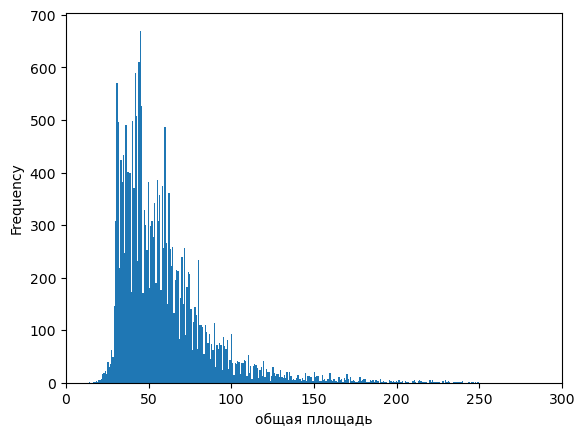

In [43]:
# Анализируем данные в столбце total_area

data['total_area'].plot(kind='hist', bins=300, xlim=(0, 300))
plt.xlabel("общая площадь")

# Построив сводную таблицу, оценим количество комнат квартир и общей площади

rooms_total_area = data.pivot_table(index='rooms', values='total_area', aggfunc='count')
rooms_total_area

***
В датасете основную массу составляют квартиры площадью от примерно 25 до 100 кв.м. При этом в глаза бросаются два пика - ближе к нижней границе - малометражные квартиры, студии и однокомнатные квартиры до 35 кв.м., и наибольшее количество квартир средней площади около 50 кв.м., судя по сводной таблице - двухкомнатным.
***

#### Жилая площадь

,living_area
rooms,
1,7890
2,7853
3,5741
4,1147
5,286
6,80
7,36


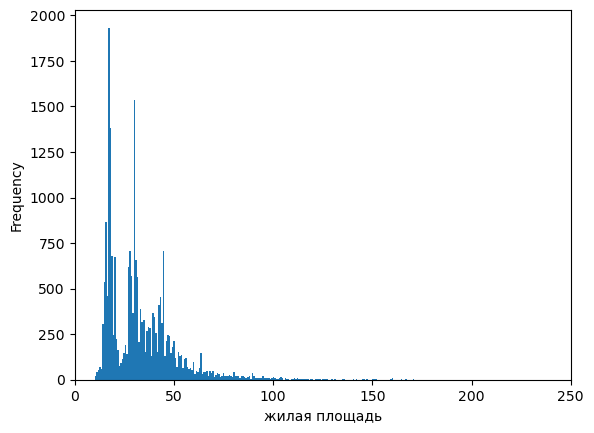

In [44]:
# Анализируем данные в столбце living_area

data['living_area'].plot(kind='hist', bins=250, xlim=(0, 250))
plt.xlabel("жилая площадь")

# Построив сводную таблицу, оценим количество комнат квартир и жилой площади

rooms_living_area = data.pivot_table(index='rooms', values='living_area', aggfunc='count')
rooms_living_area

***
Ситуация с жилой площадью соответствует ситуации с общей площадью. Два наблюдаемых пика количества значений - соответствуют малометражным квартирам, студиям и однокомнатным квартирам - с одной стороны, и двухкомнатным квартирам - с другой. Большее количество значений в "первом" пике может быть связано с тем, что в малометражных квартирах и студиях к жилой площади добавляется по факту площадь кухни.
***

#### Площадь кухни

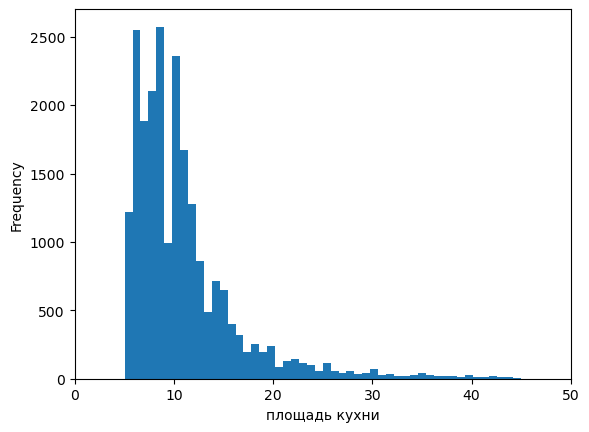

In [45]:
# Анализируем данные в столбце kitchen_area

data['kitchen_area'].plot(kind='hist', bins=50, xlim=(0, 50))
plt.xlabel("площадь кухни");

***
Разброс значений в площади кухонь меньше, чем в общей или жилой площади, и по гистограмме заметно, что основное количество значений концентрируется в диапазоне от 5-6 метров, характерных для старого жилого фонда (т.н. "хрущёвки") до 10-12 метров.
***

#### Цена объекта

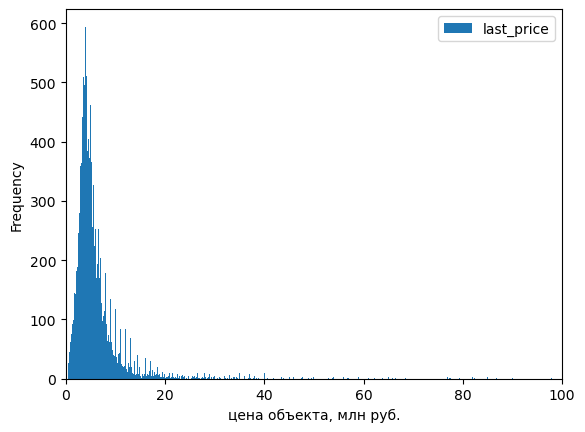

In [46]:
# Анализируем данные в столбце last_price

data_rounded = data.copy()
data_rounded['last_price'] = data_rounded['last_price'] / 1000000
data_rounded.plot(y='last_price', kind='hist', bins=1000, xlim=(0, 100))
plt.ticklabel_format(style='plain')
plt.xlabel("цена объекта, млн руб.");

***
Гистограмма по ценам на квартиры показывает нормальное распределение. Основное количество значений - до 10 млн рублей, соответствует основной массе квартир - одно- и двухкомнатных, однако двух пиков не наблюдается, резкого перехода стоимости между квартирами разной площади и планировки нет.
***

#### Количество комнат

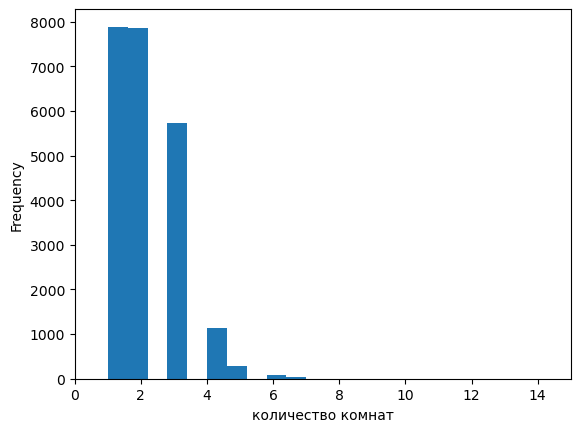

In [47]:
# Анализируем данные в столбце rooms

data['rooms'].plot(kind='hist', bins=10, xlim=(0, 15))
plt.xlabel("количество комнат");

***
Больше всего на рынке в продаже квартиры с количеством комнат от 1 до 2, дальше достаточно резкий спад, и 4-хкомнатных квартир уже существенно меньше.
***

#### Высота потолков

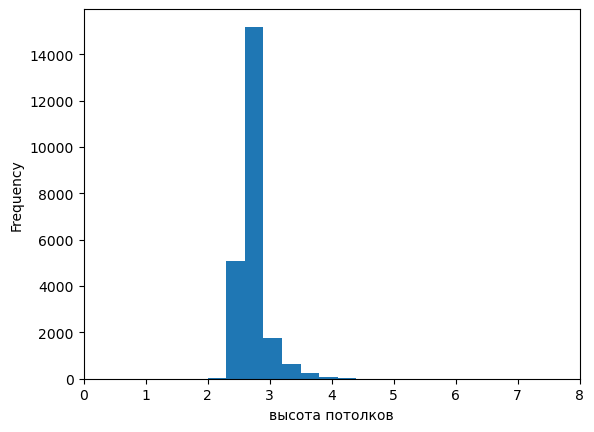

In [48]:
# Анализируем данные в столбце ceiling_height

data['ceiling_height'].plot(kind='hist', bins=20, xlim=(0, 8))
plt.xlabel("высота потолков");

***
Как уже указывалось при предобработке данных, высота потолка - величина гораздо более стандартизованная, разброс значений невелик, что подтверждает гистограмма. Почти все потолки в датасете - от 2,5 до 3 метров. Потолки более высокие характерны скорее для недвижимости более высокого класса, которой в датасете немного.
***

#### Этаж квартиры

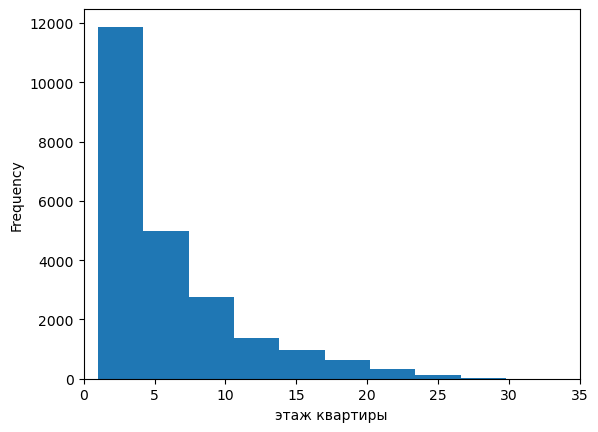

In [49]:
# Анализируем данные в столбце floor
data['floor'].plot(kind='hist', bins=10, xlim=(0, 35))
plt.xlabel("этаж квартиры");

***
Гистограмма показывает, что основное количество объявлений - о продаже квартир, расположенных на этажах до 5 включительно
***

#### Тип этажа квартиры («первый», «последний», «другой»)

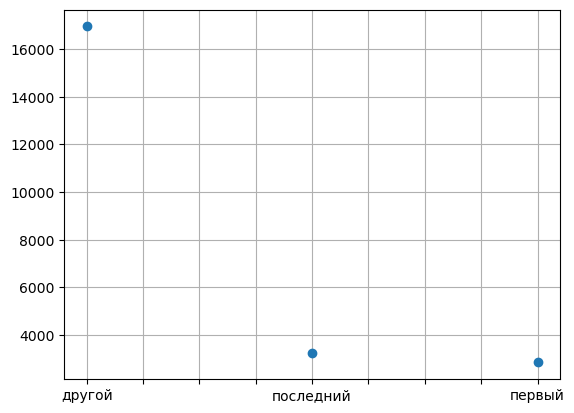

In [50]:
# Анализируем данные в столбце floor_type

floor_type_count = data['floor_type'].value_counts()
floor_type_count.plot(x='floor_type', y=floor_type_count, grid=True, style='o');

***
Объявлений о продаже квартир на первом либо последнем этажах в разы меньше, чем "промежуточных" вариантов. Полагаем, что это объясняется обычной статистической закономерностью.
***

#### Общее количество этажей в доме

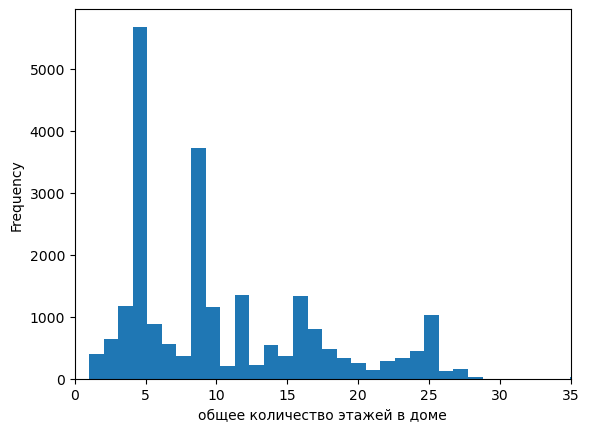

In [51]:
# Анализируем данные в столбце floors_total
data['floors_total'].plot(kind='hist', bins=35, xlim=(0, 35))
plt.xlabel("общее количество этажей в доме");

***
Больше всего в датасете объявлений о продаже квартир в 5-этажках и 9-этажках, это выглядит правдоподобно. Кроме того, прослеживается связь между таким распределением, концентрацией квартир, расположенных от 1 до 5 этажей, и выводами о площади кухонь, сделанными выше - стандартная площадь кухонь в 5-этажных "хрущевках" как раз в районе 6 кв.м., и пиковые значения это подтверждают.
***

#### Расстояние до центра города в метрах

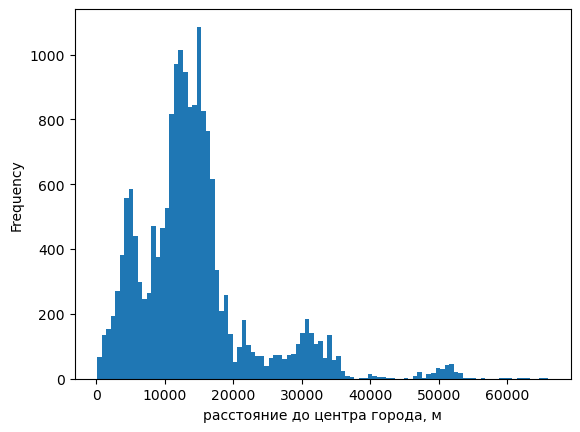

In [52]:
# Анализируем данные в столбце city_centers_nearest
data['city_centers_nearest'].plot(kind='hist', bins=100)
plt.xlabel("расстояние до центра города, м");

***
На гистограмме заметны два пика. Первый, более низкий, соответствует меньшему расстоянию до центра города. Предположительно, этот пик отражает объявления из небольших населенных пунктов с небольшим расстоянием до центра в пределах 5 км. Второй пик - более высокий, по всей видимости, отражает объявления из агломерации - Санкт-Петербурга и пригородов.
На гистограмме видны явные выбросы. Поскольку данные в столбце заполнены на основе картографической информации, и нет достаточных оснований им не доверять, можно предположить, что расстояния до центра от 35 км и выше касаются сёл и посёлков, и это расстояние до центра ближайшего города.
***

#### Расстояние до ближайшего аэропорта

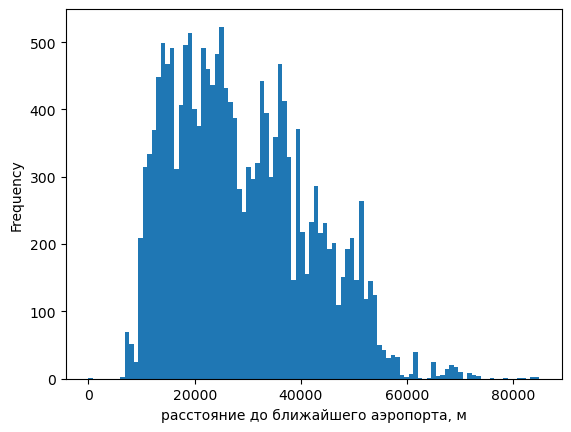

In [53]:
# Анализируем данные в столбце airports_nearest
data['airports_nearest'].plot(kind='hist', bins=100)
plt.xlabel("расстояние до ближайшего аэропорта, м");

***
Жилья в непосредственной близости от аэропорта в датасете практически нет. Видно, что разброс значений в этом столбце достаточно велик, от 10 км до 55 км, с большим количеством локальных пиковых значений. В целом это соответствует тому, что населенных пунктов в датасете много, а аэропортов в СпБ и Ленобласти достаточно мало.
***

#### Расстояние до ближайшего парка

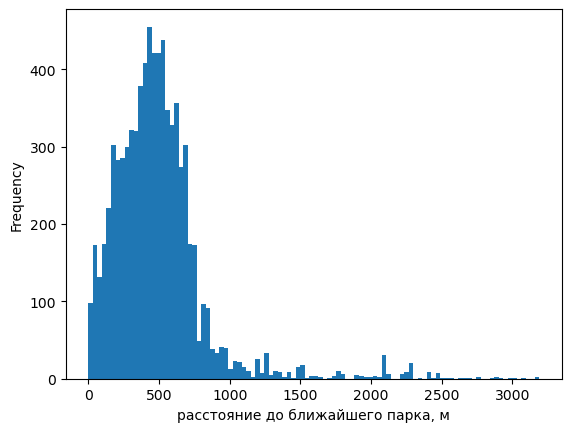

In [54]:
# Анализируем данные в столбце parks_nearest
data['parks_nearest'].plot(kind='hist', bins=100)
plt.xlabel("расстояние до ближайшего парка, м");

***
На гистограмме представлено нормальное распределение, при этом пик - в районе 500 метров до ближайшего парка, чтоможно считать хорошим показателем. Количества объявлений с парками дальше, чем в 700 метрах, существенно меньше. Следует, однако, учесть тот факт, что почти четверть значений в столбце - пропуски, и это могло существенно повлиять на статистику.
***

#### День и месяц публикации объявления

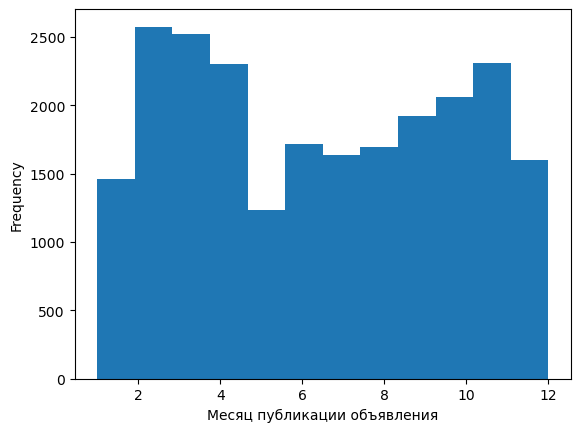

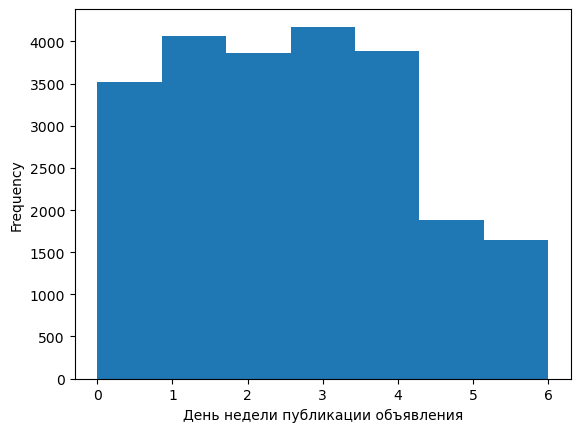

In [55]:
# Анализируем данные в столбцах exp_month и exp_weekday

data['exp_month'].plot(kind='hist', bins=12)
plt.xlabel("Месяц публикации объявления")
plt.show()
data['exp_weekday'].plot(kind='hist', bins=7)
plt.xlabel("День недели публикации объявления")
plt.show()

***
Чаще всего объявления о продаже публиковались в начале года (фавраль-апрель), в начале лета следовал спад, который сменялся постепенным ростом к концу года, до ноября. Месяцы "затишья" - май, декабрь, январь.

Что касается дней недели, то объявления реже всего публикуются по выходным.
***

****
**Промежуточные выводы по этапу 4.1**

После изучения параметров объектов в датасете можно сделать следующие выводы:

1) В датасете основную массу составляют квартиры площадью от примерно 25 до 100 кв.м. При этом в глаза бросаются два пика - ближе к нижней границе - малометражные квартиры, студии и однокомнатные квартиры до 35 кв.м., и наибольшее количество квартир средней площади около 50 кв.м., судя по сводной таблице - двухкомнатным.

2) Ситуация с жилой площадью соответствует ситуации с общей площадью. Два наблюдаемых пика количества значений - соответствуют малометражным квартирам, студиям и однокомнатным квартирам - с одной стороны, и двухкомнатным квартирам - с другой. Большее количество значений в "первом" пике может быть связано с тем, что в малометражных квартирах и студиях к жилой площади добавляется по факту площадь кухни.

3) Разброс значений в площади кухонь меньше, чем в общей или жилой площади, и по гистограмме заметно, что основное количество значений концентрируется в диапазоне от 5-6 метров, характерных для старого жилого фонда (т.н. "хрущёвки"), и до 10-12 метров.

4) Цены на квартиры показывают нормальное распределение. Основное количество значений - до 10 млн рублей, соответствует основной массе квартир - одно- и двухкомнатных, однако двух пиков не наблюдается, резкого перехода стоимости между квартирами разной площади и планировки нет.

5) Больше всего на рынке в продаже квартиры с количеством комнат от 1 до 2, дальше достаточно резкий спад, и 4-хкомнатных квартир уже существенно меньше.

6) Разброс значений высоты потолка невелик. Почти все потолки в датасете - от 2,5 до 3 метров. Потолки более высокие характерны скорее для недвижимости более высокого класса, которой в датасете немного.

7) Основное количество объявлений - о продаже квартир, расположенных на этажах до 5 включительно.

8) Объявлений о продаже квартир на первом либо последнем этажах в разы меньше, чем "промежуточных" вариантов. Полагаем, что это объясняется обычной статистической закономерностью.

9) Больше всего в датасете объявлений о продаже квартир в 5-этажках и 9-этажках, это выглядит правдоподобно. Кроме того, прослеживается связь между таким распределением, концентрацией квартир, расположенных от 1 до 5 этажей, и выводами о площади кухонь, сделанными выше - стандартная площадь кухонь в 5-этажных "хрущевках" как раз в районе 6 кв.м., и пиковые значения это подтверждают.

10) По расстоянию до центра города объявления делятся на два основных массива: объявления из небольших населенных пунктов с небольшим расстоянием до центра в пределах 5 км, и объявления из агломерации - Санкт-Петербурга и пригородов. Можно предположить, что расстояния до центра от 35 км и выше касаются сёл и посёлков, и это расстояние до центра ближайшего города.

11) Жилья в непосредственной близости от аэропорта в датасете практически нет. Видно, что разброс значений в этом столбце достаточно велик, от 10 км до 55 км, с большим количеством локальных пиковых значений. В целом это соответствует тому, что населенных пунктов в датасете много, а аэропортов в СпБ и Ленобласти достаточно мало.

12) Больше всего в датасете объектов недвижимости с расстоянием в районе 500 метров до ближайшего парка, что можно считать хорошим показателем. Количества объявлений с парками дальше, чем в 700 метрах, существенно меньше. Следует, однако, учесть тот факт, что почти четверть значений в столбце - пропуски, и это могло существенно повлиять на статистику.

13) Чаще всего объявления о продаже публиковались в начале года (фавраль-апрель), в начале лета следовал спад, который сменялся постепенным ростом к концу года, до ноября. Месяцы "затишья" - май, декабрь, январь. Что касается дней недели, то объявления реже всего публикуются по выходным.

****

### Изучение быстроты продажи квартир <a id='3.2'></a>

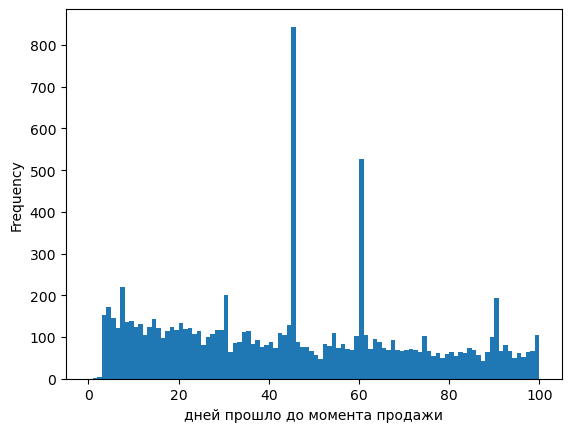

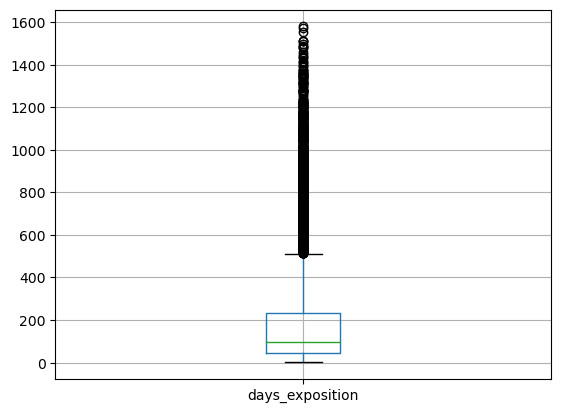

count    19929.000000
mean       181.264037
std        219.696215
min          1.000000
25%         45.000000
50%         96.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

In [56]:
# Изучим, как быстро продавались квартиры


data['days_exposition'].plot(kind='hist', bins=100, range=(0, 100))
plt.xlabel("дней прошло до момента продажи");
plt.show()

data.boxplot(column='days_exposition')

plt.show()
data['days_exposition'].describe()

***
**Промежуточные выводы по этапу 4.2**

Исходя из значений в столбце days_exposition, основная масса квартир была продана в течение 150-200 дней, т.е. 5-6 месяцев. Средний срок продажи (181 день) тяготеет именно к этим значениям. Медианное значение ниже - 96 дней, т.е. 3 месяца.
Быстрыми можно считать продажи в пределах первого квартиля, - это 1,5 месяца. Необычно долгие продажи - те, которые выходят за пределы межквартильного размаха, то есть дольше 8 месяцев.
***

### Какие факторы больше всего влияют на общую (полную) стоимость объекта? <a id='3.3'></a>

#### Зависимость цены квартиры от общей площади

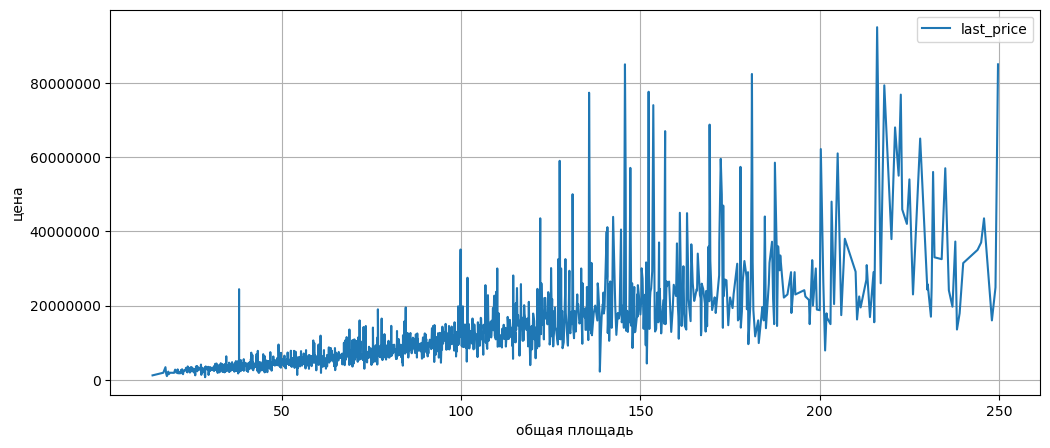

In [57]:
# Изучим зависимость цены квартиры от общей площади. Для этого сгруппируем данные в сводную таблицу по медианным значениям

data.pivot_table(index='total_area', values='last_price', aggfunc='median').plot(grid=True, figsize=(12, 5))
plt.xlabel("общая площадь");
plt.ylabel("цена");
plt.ticklabel_format(style='plain')

***
Судя по графику, между общей площадью и ценой квартиры есть прямая зависимость. При этом, чем выше площадь, тем больше разброс есть в медианных значениях цен.
***

#### Зависимость цены квартиры от жилой площади

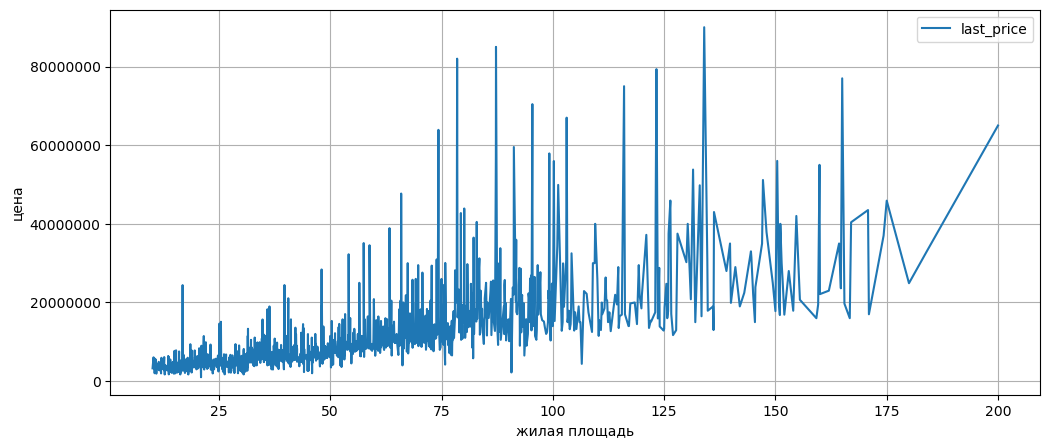

In [58]:
# Изучим зависимость цены квартиры от жилой площади. Для этого сгруппируем данные в сводную таблицу по медианным значениям

data.pivot_table(index='living_area', values='last_price', aggfunc='median').plot(grid=True, figsize=(12, 5))
plt.xlabel("жилая площадь");
plt.ylabel("цена");
plt.ticklabel_format(style='plain')

***
Прямая зависимость между жилой площадью и ценой квартиры также прослеживается. По графику видно, как разнится цена, особенно при высоких значениях жилой площади, от 60 кв.м. Это, в частности, может быть связано как с невысокой достоверностью данных о жилой площади, так и с другими факторами, влияющими на цены жилья высокого класса (большой площади).
***

#### Зависимость цены квартиры от площади кухни

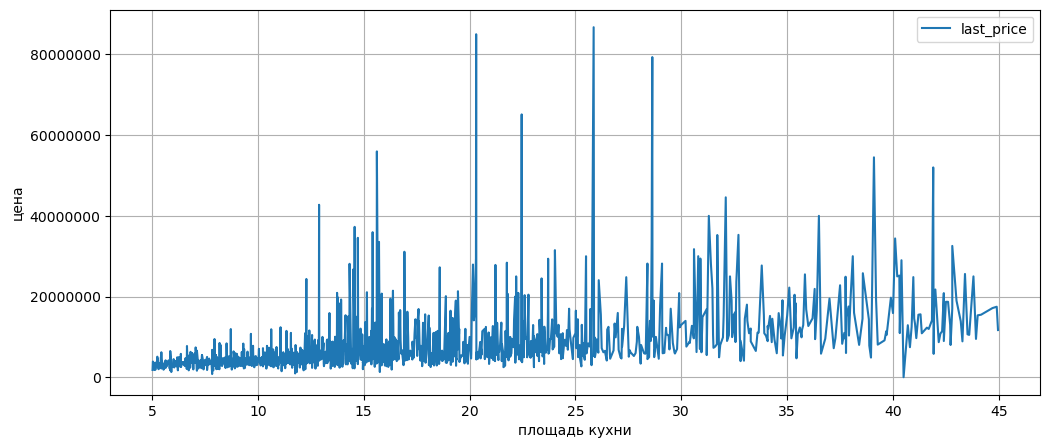

In [59]:
# Изучим зависимость цены квартиры от площади кухни. Для этого сгруппируем данные в сводную таблицу по медианным значениям

data.pivot_table(index='kitchen_area', values='last_price', aggfunc='median').plot(grid=True, figsize=(12, 5))
plt.xlabel("площадь кухни");
plt.ylabel("цена");
plt.ticklabel_format(style='plain')

***
Зависимость между площадью кухни и ценой квартиры прослеживается, но она гораздо менее чёткая. Разброс цен, как и в случае с жилой площадью, начинается с больших площадей, от 12 кв.м. Это, в частности, может быть связано как с невысокой достоверностью данных о площади кухни, так и с другими факторами, влияющими на цены жилья высокого класса (большой площади).
***

#### Зависимость цены квартиры от количества комнат

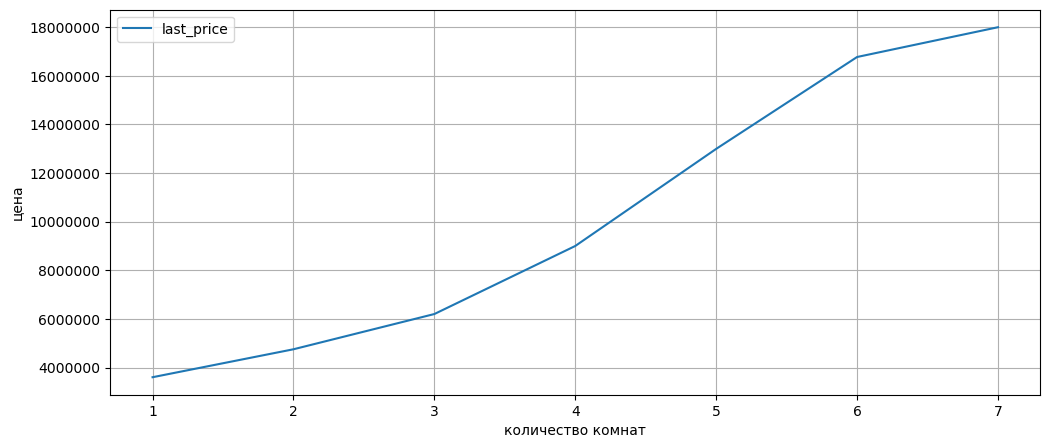

In [60]:
# Изучим зависимость цены квартиры от количества комнат. Для этого сгруппируем данные в сводную таблицу по медианным значениям

data.pivot_table(index='rooms', values='last_price', aggfunc='median').plot(grid=True, figsize=(12, 5))
plt.xlabel("количество комнат");
plt.ylabel("цена");
plt.ticklabel_format(style='plain')

***
Зависимость цены квартиры от количества комнат прямая.
***

#### Матрица корреляций

In [61]:
# Рассчитаем коэффициенты корреляции Пирсона для общей цены и ряда параметров

data[['last_price', 'total_area', 'rooms', 'living_area', 'kitchen_area']].corr()

,last_price,total_area,rooms,living_area,kitchen_area
last_price,1.000000,0.743872,0.448578,0.621713,0.472384
total_area,0.743872,1.000000,0.787734,0.916275,0.510982
rooms,0.448578,0.787734,1.000000,0.879245,0.196790
living_area,0.621713,0.916275,0.879245,1.000000,0.302144
kitchen_area,0.472384,0.510982,0.196790,0.302144,1.000000


***
Вывод: между ценой, с одной стороны, и общей площадью, жилой площадью, площадью кухни и количеством комнат, с другой стороны - прямая зависимость. При этом:
- самая тесная взаимосвязь - между ценой и общей площадью (коэффициент 0,74);
- взаимосвязь между ценой и жилой площадью слабее, чем с общей площадью, но коэффициент все же выше 0,5 (как правило, с увеличением общей площадью растет и жилая, тут неожиданностей нет);
- слабее всего (и практически на одном уровне) взаимосвязь между ценой, площадью кухни и количеством комнат - коэффициенты 0,47 и 0,44 соответственно. Это выглядит правдоподобно - всё же, увеличение площади кухни и количества комнат не может происходить строго линейно по мере увеличения общей площади, всему есть предел.
***

#### Зависимость цены квартиры от этажа, на котором расположена квартира (первый, последний, другой)

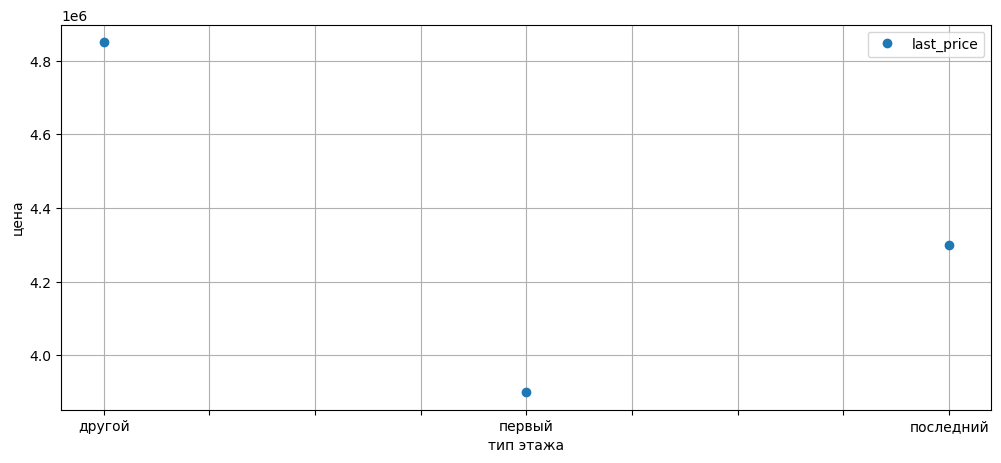

In [62]:
# Изучим зависимость цены квартиры от этажа, на котором расположена квартира (первый, последний, другой).
# Для этого сгруппируем данные в сводную таблицу по медианным значениям

data.pivot_table(index='floor_type', values='last_price', aggfunc='median').plot(grid=True, figsize=(12, 5), style='o')
plt.xlabel("тип этажа");
plt.ylabel("цена");

***
Квартиры на первом этаже - самые дешевые. Квартиры на последнем этаже в целом дороже квартир на первом этаже, но больше всего ценятся квартиры между первым и последним этажами.
***

#### Зависимость цены квартиры от дня недели размещения объявления

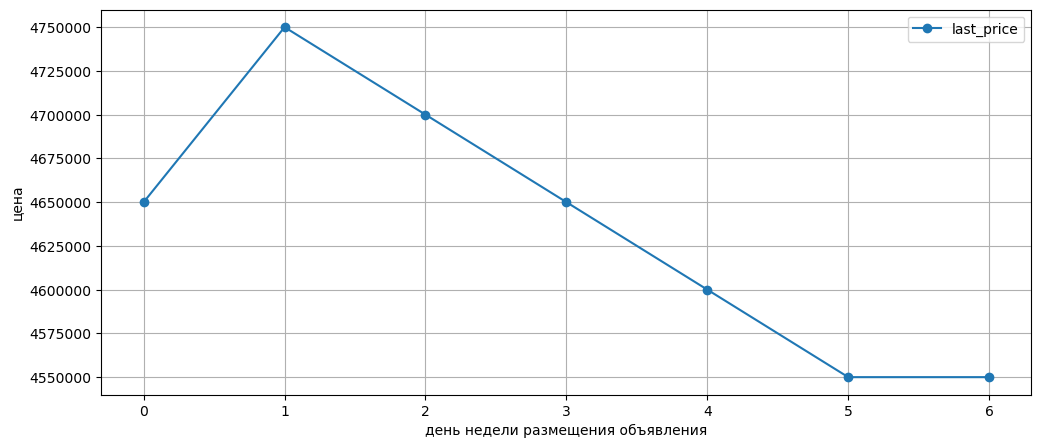

In [63]:
# Изучим зависимость цены квартиры от дня недели размещения объявления. Для этого сгруппируем данные в сводную таблицу по медианным значениям

data.pivot_table(index='exp_weekday', values='last_price', aggfunc='median').plot(grid=True, figsize=(12, 5), style='o-')
plt.xlabel("день недели размещения объявления");
plt.ylabel("цена");
plt.ticklabel_format(style='plain')

***
Здесь зависимость, судя по всему, связана с ранее исследованной закономерностью - в выходные дни публикуется меньше всего объявлений.
***

#### Зависимость цены квартиры от месяца размещения объявления

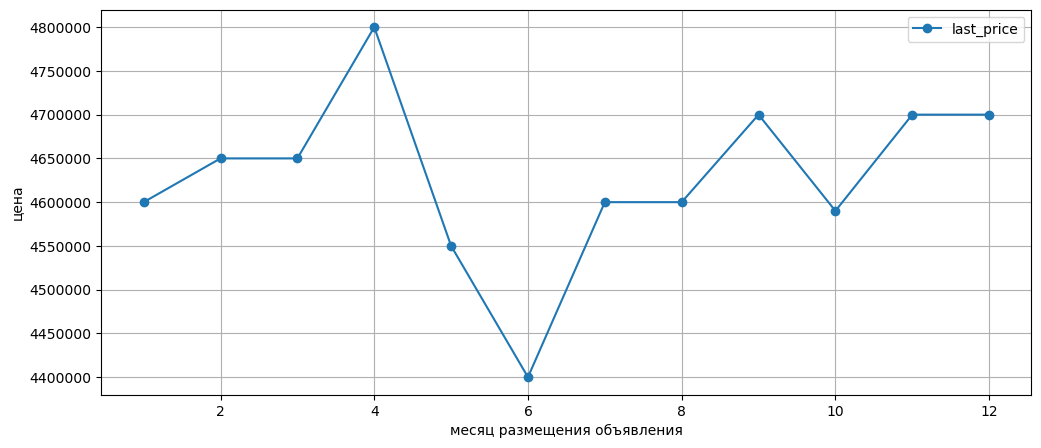

In [64]:
# Изучим зависимость цены квартиры от месяца размещения объявления. Для этого сгруппируем данные в сводную таблицу по медианным значениям

data.pivot_table(index='exp_month', values='last_price', aggfunc='median').plot(grid=True, figsize=(12, 5), style='o-')
plt.xlabel("месяц размещения объявления");
plt.ylabel("цена");
plt.ticklabel_format(style='plain')

***
Здесь зависимость, судя по всему, связана с ранее исследованной закономерностью - больше всего объявлений публикуется в феврале-апреле, затем идет спад к началу лета, затем снова подъем. Впрочем, на этом графике видно, что цены в объявлениях, опубликованных в октябре, снижаются, а затем возвращаются на прежние высокие позиции. Причина снижения цен в окт ябре неясна, а вот в ноябре-декабре при снижении количества объявлений цена не снижается. Возможно, под конец года владельцы стараются продать свою недвижимость как можно дороже.
***

#### Зависимость цены квартиры от года размещения объявления

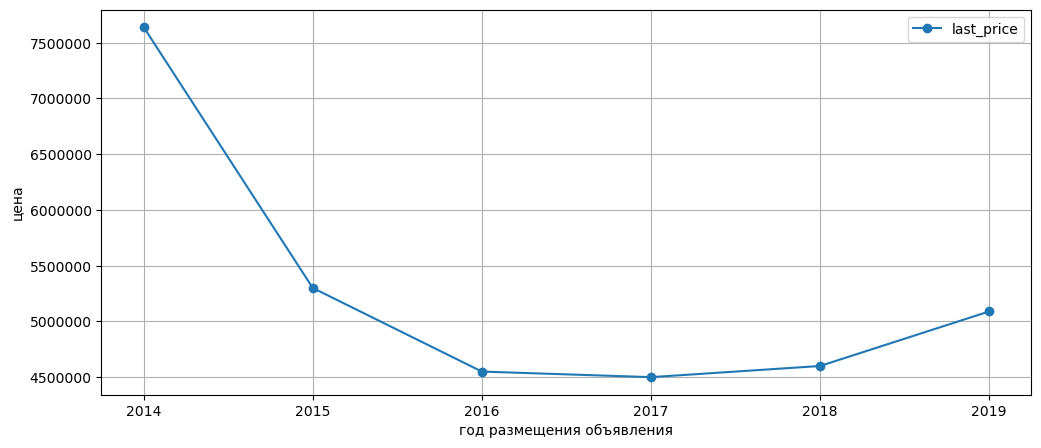

In [65]:
# Изучим зависимость цены квартиры от года размещения объявления. Для этого сгруппируем данные в сводную таблицу по медианным значениям

data.pivot_table(index='exp_year', values='last_price', aggfunc='median').plot(grid=True, figsize=(12, 5), style='o-')
plt.xlabel("год размещения объявления");
plt.ylabel("цена");
plt.ticklabel_format(style='plain')

***
На графике хорошо виден непрерывный спад цен с 2014 года (первый год, отраженный в датасете) и до 2017 года. После 2017 года до 2019 года наблюдается постепенный рост цен.
***

***
**Промежуточные выводы по этапу 4.3**

По итогам изучения влияния различных факторов на общую (полную) стоимость объекта, можно сделать следующие выводы:

+ Между общей площадью и ценой квартиры есть прямая зависимость (коэффициент корреляции Пирсона 0,74). При этом, чем выше площадь, тем больше разброс есть в медианных значениях цен.

+ Прямая зависимость между жилой площадью и ценой квартиры также прослеживается (коэффициент корреляции Пирсона 0,62), но она ниже, чем между ценой и общей площадью. При высоких значениях жилой площади, от 60 кв.м., цена сильно разнится. Это, в частности, может быть связано как с невысокой достоверностью данных о жилой площади, так и с другими факторами, влияющими на цены жилья высокого класса (большой площади).

+ Зависимость между площадью кухни и ценой квартиры прослеживается, но слабая (коэффициент корреляции Пирсона 0,47). Разброс цен, как и в случае с жилой площадью, начинается с больших площадей, от 12 кв.м. Это, в частности, может быть связано как с невысокой достоверностью данных о площади кухни, так и с другими факторами, влияющими на цены жилья высокого класса (большой площади).

+ Зависимость цены квартиры от количества комнат прямая, но слабая (коэффициент корреляции Пирсона 0,44).

+ Квартиры на первом этаже - самые дешевые. Квартиры на последнем этаже в целом дороже квартир на первом этаже, но больше всего ценятся квартиры между первым и последним этажами.

+ Цена опубликованных в выходные объектов ниже - в выходные дни публикуется меньше всего объявлений.

+ Зависимость от месяца публикации объявления: больше всего объявлений публикуется в феврале-апреле, затем идет спад к началу лета, затем снова подъем. Впрочем, на этом графике видно, что цены в объявлениях, опубликованных в октябре, снижаются, а затем возвращаются на прежние высокие позиции. Причина снижения цен в окт ябре неясна, а вот в ноябре-декабре при снижении количества объявлений цена не снижается. Возможно, под конец года владельцы стараются продать свою недвижимость как можно дороже.

+ С 2014 года (первый год, отраженный в датасете) и до 2017 года шел непрерывный спад цен. После 2017 года до 2019 года наблюдается постепенный рост цен.

***

### Изучение средней цены одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. <a id='3.4'></a>

In [66]:
# Посчитаем среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений.

# Формируем список населенных пунктов с наибольшим количеством объявлений
top_10 = data['locality_name'].value_counts().head(10)
top_10_list = list(top_10.index)

# Создаем сводную таблицу по населенным пунктам, со средними значениями цены и общей площади
locality_price = data.pivot_table(index='locality_name', values=('last_price', 'total_area')).reset_index()

# Добавляем в сводную таблицу столбец с вычислением средней цены одного квадратного метра
locality_price['one_meter_price'] = locality_price['last_price'] / locality_price['total_area']

# Вбираем из сводной таблицы строки с населенными пунктами с наибольшим количеством объявлений и сортируем
locality_price.query('locality_name in @top_10_list').sort_values(by='one_meter_price', ascending=False)

,locality_name,last_price,total_area,one_meter_price
34,Санкт-Петербург,7.432321e+06,62.845225,118263.895933
33,Пушкин,6.305546e+06,59.904877,105259.309005
80,деревня Кудрово,4.336838e+06,47.851047,90632.047102
210,поселок Парголово,4.522572e+06,51.932336,87085.847328
23,Мурино,3.758004e+06,45.393266,82787.707669
261,поселок Шушары,4.127019e+06,54.225255,76108.789980
14,Колпино,3.870386e+06,52.369672,73905.099796
7,Гатчина,3.485542e+06,50.975182,68377.244346
4,Всеволожск,3.825110e+06,56.588151,67595.597991
5,Выборг,3.275269e+06,56.519487,57949.379837


***
**Промежуточные выводы по этапу 4.4**

Самая высокая средняя цена квадратного метра - в Санкт-Петербурге, самая низкая (из топ-10) - в Выборге
***

### Изучение средней цены каждого километра в Санкт-Петербурге <a id='3.5'></a>

Коэффициент корреляции Пирсона между расстоянием от центра города в Санкт-Петербурге и стоимостью квартир: -0.3791726972046092


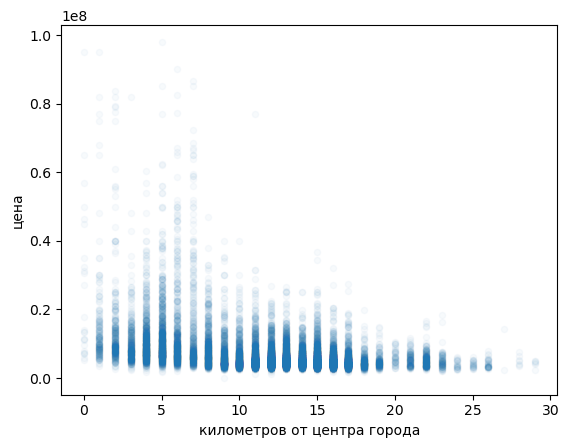

In [67]:
# Изучим, как влияет расстояние от центра города в Санкт-Петербурге на стоимость квартир

# Отбираем строки, соответствующие объявлениям из Санкт-Петербурга
data_spb = data[data['locality_name'] == 'Санкт-Петербург']

# Строим диаграмму рассеяния... 
data_spb.plot(x='city_centers_km', y='last_price', kind='scatter', alpha=0.03)
plt.xlabel("километров от центра города");
plt.ylabel("цена");

# ...и считаем коэффициент Пирсона
print(f"Коэффициент корреляции Пирсона между расстоянием от центра города в Санкт-Петербурге и стоимостью квартир: "\
      f"{data_spb['last_price'].corr(data_spb['city_centers_km'])}")

In [68]:
# вычислим среднюю стоимость каждого километра в СпБ, построив сводную таблицу по значениям из столбца city_centers_km

spb_km_price = data_spb.pivot_table(index='city_centers_km', values='last_price')
spb_km_price['last_price'] = round(spb_km_price['last_price'])
spb_km_price

,last_price
city_centers_km,
0.0,26285045.0
1.0,14873006.0
2.0,14215993.0
3.0,10406865.0
4.0,11197954.0
5.0,12138471.0
6.0,12647368.0
7.0,13504046.0
8.0,9061921.0


***
**Промежуточные выводы по этапу 4.5**

Между расстоянием от центра и ценой существует обратная зависимость. При этом, коэффициент корреляции Пирсона -0.38. Это, с одной стороны, должно свидетельствовать о невысокой взаимосвязи. А с другой стороны - факторов, влияющих на цену недвижимости, очень много. Поэтому представляется, что низкое значение коэффициент корреляции не должно смущать. Тем более, что при оценке средней цены каждого километра заметна взаимосвязь - чем ближе к центру - тем дороже. Это вполне ожидаемо и не противоречит здравому смыслу.
***

***
## Общий вывод <a id='5'></a>
В датасете были обнаружены и по мере возможности устранены недостатки: пропущенные значения, неправильные типы данных, аномальные значения. В результате очистки для анализа сохранилось 23033 строки из 23699 первоначальных.

**По итогам предобработки данных можно дать следующие рекомендации:**
- уделить внимание заполнению и достоверности внутренних параметров квартир - площади кухни, жилой площади, высоты потолков;
- совершенствовать алгоритм заполнения картографических данных, минимизировать сбои;
- предотвращать заполнение ряда столбцов аномальными значениями, например, путем ограничения диапазона значений для высоты потолка.

**После изучения параметров объектов в датасете можно сделать следующие выводы:**

1) В датасете основную массу составляют квартиры площадью от примерно 25 до 100 кв.м. При этом в глаза бросаются два пика - ближе к нижней границе - малометражные квартиры, студии и однокомнатные квартиры до 35 кв.м., и наибольшее количество квартир средней площади около 50 кв.м., судя по сводной таблице - двухкомнатным.

2) Ситуация с жилой площадью соответствует ситуации с общей площадью. Два наблюдаемых пика количества значений - соответствуют малометражным квартирам, студиям и однокомнатным квартирам - с одной стороны, и двухкомнатным квартирам - с другой. Большее количество значений в "первом" пике может быть связано с тем, что в малометражных квартирах и студиях к жилой площади добавляется по факту площадь кухни.

3) Разброс значений в площади кухонь меньше, чем в общей или жилой площади, и по гистограмме заметно, что основное количество значений концентрируется в диапазоне от 5-6 метров, характерных для старого жилого фонда (т.н. "хрущёвки") до 10-12 метров.

4) Цены на квартиры показывают нормальное распределение. Основное количество значений - до 10 млн рублей, соответствует основной массе квартир - одно- и двухкомнатных, однако двух пиков не наблюдается, резкого перехода стоимости между квартирами разной площади и планировки нет.

5) Больше всего на рынке в продаже квартиры с количеством комнат от 1 до 2, дальше достаточно резкий спад, и 4-хкомнатных квартир уже существенно меньше.

6) Разброс значений высоты потолка невелик. Почти все потолки в датасете - от 2,5 до 3 метров. Потолки более высокие характерны скорее для недвижимости более высокого класса, которой в датасете немного.

7) Основное количество объявлений - о продаже квартир, расположенных на этажах до 5 включительно.

8) Объявлений о продаже квартир на первом либо последнем этажах в разы меньше, чем "промежуточных" вариантов. Полагаем, что это объясняется обычной статистической закономерностью.

9) Больше всего в датасете объявлений о продаже квартир в 5-этажках и 9-этажках, это выглядит правдоподобно. Кроме того, прослеживается связь между таким распределением, концентрацией квартир, расположенных от 1 до 5 этажей, и выводами о площади кухонь, сделанными выше - стандартная площадь кухонь в 5-этажных "хрущевках" как раз в районе 6 кв.м., и пиковые значения это подтверждают.

10) По расстоянию до центра города объявления делятся на два основных массива: объявления из небольших населенных пунктов с небольшим расстоянием до центра в пределах 5 км, и объявления из агломерации - Санкт-Петербурга и пригородов. Можно предположить, что расстояния до центра от 35 км и выше касаются сёл и посёлков, и это расстояние до центра ближайшего города.

11) Жилья в непосредственной близости от аэропорта в датасете практически нет. Видно, что разброс значений в этом столбце достаточно велик, от 10 км до 55 км, с большим количеством локальных пиковых значений. В целом это соответствует тому, что населенных пунктов в датасете много, а аэропортов в СпБ и Ленобласти достаточно мало.

12) Больше всего в датасете объектов недвижимости с расстоянием в районе 500 метров до ближайшего парка, что можно считать хорошим показателем. Количества объявлений с парками дальше, чем в 700 метрах, существенно меньше. Следует, однако, учесть тот факт, что почти четверть значений в столбце - пропуски, и это могло существенно повлиять на статистику.

13) Чаще всего объявления о продаже публиковались в начале года (февраль-апрель), в начале лета следовал спад, который сменялся постепенным ростом к концу года, до ноября. Месяцы "затишья" - май, декабрь, январь. Что касается дней недели, то объявления реже всего публикуются по выходным.


**Основная масса квартир была продана в течение 150-200 дней, т.е. 5-6 месяцев. Средний срок продажи (181 день) тяготеет именно к этим значениям. Медианное значение ниже - 96 дней, т.е. 3 месяца. Быстрыми можно считать продажи в пределах первого квартиля, - это 1,5 месяца. Необычно долгие продажи - те, которые выходят за пределы межквартильного размаха, то есть дольше 8 месяцев.**


**По итогам изучения влияния различных факторов на общую (полную) стоимость объекта, можно сделать следующие выводы:**

- Между общей площадью и ценой квартиры есть прямая зависимость (коэффициент корреляции Пирсона 0,74). При этом, чем выше площадь, тем больше разброс есть в медианных значениях цен.

- Прямая зависимость между жилой площадью и ценой квартиры также прослеживается (коэффициент корреляции Пирсона 0,62), но она ниже, чем между ценой и общей площадью. При высоких значениях жилой площади, от 60 кв.м., цена сильно разнится. Это, в частности, может быть связано как с невысокой достоверностью данных о жилой площади, так и с другими факторами, влияющими на цены жилья высокого класса (большой площади).

- Зависимость между площадью кухни и ценой квартиры прослеживается, но слабая (коэффициент корреляции Пирсона 0,47). Разброс цен, как и в случае с жилой площадью, начинается с больших площадей, от 12 кв.м. Это, в частности, может быть связано как с невысокой достоверностью данных о площади кухни, так и с другими факторами, влияющими на цены жилья высокого класса (большой площади).

- Зависимость цены квартиры от количества комнат прямая, но слабая (коэффициент корреляции Пирсона 0,44).

- Квартиры на первом этаже - самые дешевые. Квартиры на последнем этаже в целом дороже квартир на первом этаже, но больше всего ценятся квартиры между первым и последним этажами.

- Цена опубликованных в выходные объектов ниже - в выходные дни публикуется меньше всего объявлений.

- Зависимость от месяца публикации объявления: больше всего объявлений публикуется в феврале-апреле, затем идет спад к началу лета, затем снова подъем. Впрочем, на этом графике видно, что цены в объявлениях, опубликованных в октябре, снижаются, а затем возвращаются на прежние высокие позиции. Причина снижения цен в окт ябре неясна, а вот в ноябре-декабре при снижении количества объявлений цена не снижается. Возможно, под конец года владельцы стараются продать свою недвижимость как можно дороже.

- С 2014 года (первый год, отраженный в датасете) и до 2017 года шел непрерывный спад цен. После 2017 года до 2019 года наблюдается постепенный рост цен.

**Если взять топ-10 населенных пунктов, из которых больше всего объявлений, то это Санкт-Петербург, Пушкин, деревня Кудрово, поселок Парголово,	Мурино,	поселок Шушары,	Колпино, Гатчина, Всеволожск, Выборг. Самая высокая средняя цена квадратного метра - в Санкт-Петербурге, самая низкая (из топ-10) - в Выборге**


**Между расстоянием от центра и ценой существует обратная зависимость. При этом, коэффициент корреляции Пирсона -0.38. Это, с одной стороны, должно свидетельствовать о невысокой взаимосвязи. А с другой стороны - факторов, влияющих на цену недвижимости, очень много. Поэтому представляется, что низкое значение коэффициент корреляции не должно смущать. Тем более, что при оценке средней цены каждого километра заметна взаимосвязь - чем ближе к центру - тем дороже. Это вполне ожидаемо и не противоречит здравому смыслу.**

***